# Creating a ParticleListCEM

In this tutorial we are going to create a Chemical Evolution Model from a set of individual simple stellar populations (referred to as "particles"). This is a common way of producing synthetic observations from cosmological hydrodynamical simulations.

For that purpose, PST provides the `ParticleListCEM` class. The three input arguments required for creating the model are the following:

- `time_form`: cosmic time when each particle was formed
- `metallicities`: metallicity of the particles
- `masses`: stellar mass of the particles


Import the required moduels for running this tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pst.SSP import PopStar
from pst import models
from astropy import units as u

## Stellar particles

Let's start by creating some mock particle data

In [2]:
np.random.seed(50)

# Number of particles
n_particles = 10000
today = 13.7 << u.Gyr
mass_formation_slope = .25
metallicity_today = 0.02
metallicity_slope = 4
metallicity_scatter = .4

# Randmonly sample the properties of each particle
particles_mass = 10**(np.random.uniform(5, 6, n_particles)) << u.Msun
particles_t_form = np.random.uniform(0, 1, n_particles)
particles_z = metallicity_today * np.power(particles_t_form, metallicity_slope)
particles_z *= np.random.lognormal(mean=0, sigma=metallicity_scatter, size=n_particles)
particles_t_form = today * np.power(particles_t_form, 1/mass_formation_slope)

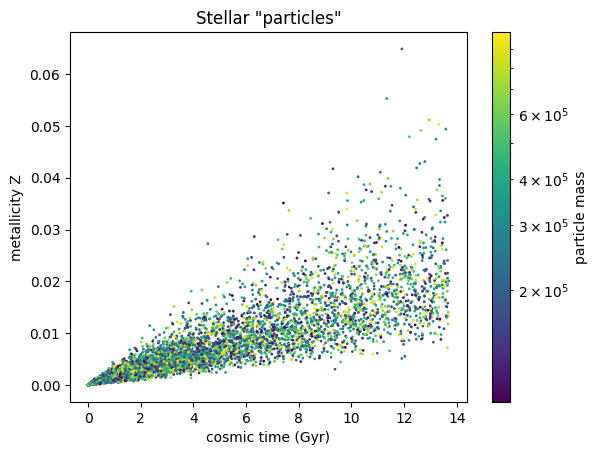

In [13]:
fig, ax = plt.subplots()

ax.set_title('Stellar "particles"')
ax.set_xlabel("cosmic time (Gyr)")
ax.set_ylabel('metallicity Z')

mappable = ax.scatter(particles_t_form.to_value(u.Gyr), particles_z,
                      s=1, c=particles_mass.to_value(u.Msun), norm=LogNorm())

plt.colorbar(mappable, ax=ax, label="particle mass")

## Chemical Evolution Model

In [4]:
sfh_model = models.ParticleListCEM(time_form=particles_t_form, metallicities=particles_z, masses=particles_mass)

To evaluate our model, let's define an array of times

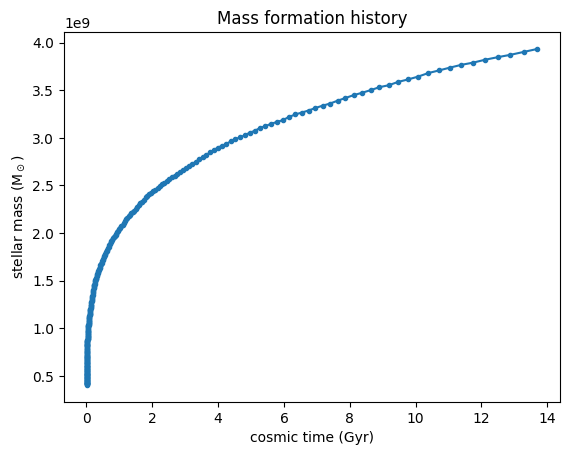

In [12]:
cosmic_time = np.geomspace(1e-4, 1, 300) * today
mass_history = sfh_model.stellar_mass_formed(cosmic_time)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Mass formation history')
ax.set_xlabel("cosmic time (Gyr)")
ax.set_ylabel(r"stellar mass (M$_\odot$)")

ax.plot(cosmic_time, mass_history, '.-')

## Spectral Energy Distribution

In [6]:
ssp = PopStar(IMF='cha')
ssp.cut_wavelength(3000, 9000)

> Initialising Popstar models (IMF='cha')
--> Only stellar continuum
[SSP] Models cut between 3000.0 Angstrom 9000.0 Angstrom


Interpolate the CEM to the SSP ages and metallicities

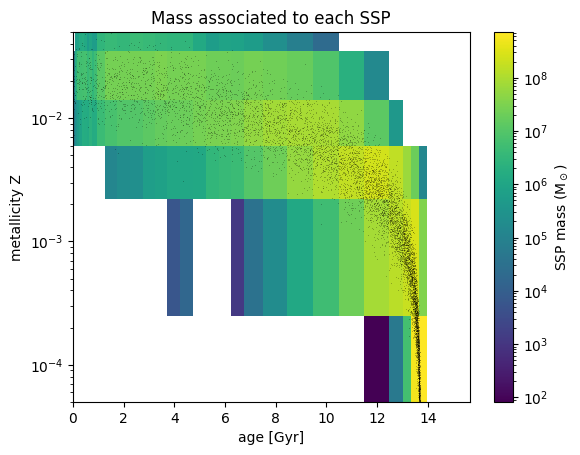

In [11]:
ssp_weights = sfh_model.interpolate_ssp_masses(ssp, t_obs=today)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f'Mass associated to each SSP')
ax.set_xlabel('age [Gyr]')
ax.set_ylabel('metallicity Z')
ax.set_yscale('log')
ax.set_ylim(5e-5, 0.05)

mappable = ax.pcolormesh(ssp.ages.to_value("Gyr"), ssp.metallicities, ssp_weights, norm=LogNorm())
ax.plot((today - particles_t_form).to_value(u.Gyr), particles_z, 'k,', alpha=.25)

plt.colorbar(mappable, ax=ax, label=r"SSP mass (M$_\odot$)")

Finally, generate the associated spectrum

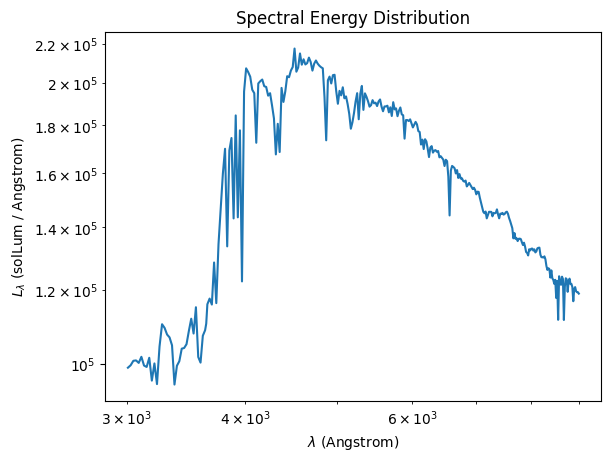

In [14]:
sed = sfh_model.compute_SED(ssp, t_obs=today)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Spectral Energy Distribution')
ax.set_xlabel(r"$\lambda$ " + f"({ssp.wavelength.unit})")
ax.set_ylabel(r"$L_\lambda$ " + f"({sed.unit})")

ax.loglog(ssp.wavelength, sed)